In [2]:
# Imports
import pymssql
import pandas as pd
import numpy as np
from config import database
from config import username
from config import password
from config import server
from config import asthma_table
from config import aq_table
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from joblib import dump
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### Random Forest Regressor - No Imputation (NO2, PM25, Ozone)

C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Fitting 5 folds for each of 6384 candidates, totalling 31920 fits
The best parameters are: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5000}
The MSE for forest was 154.31
The R^2 score for non-imputed train set is 0.9102216178807544
The R^2 score for non-imputed test set is 0.19343136448915021


Text(0.5, 1.0, 'Test Set - Score Actual vs. Predicted')

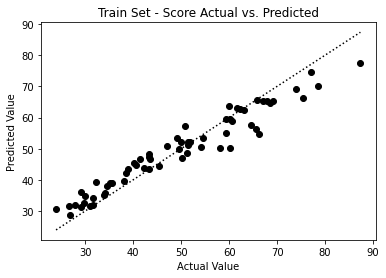

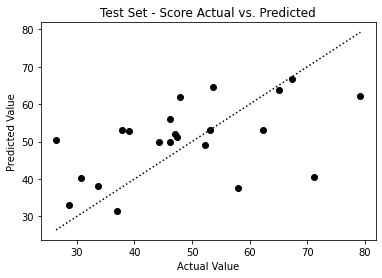

In [9]:
# Read in the data from the SQL Database
conn = pymssql.connect(server,username,password,database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query,conn)

#=================================================================================================================================================================#
### Clean it 
# Drop unnecessary columns
df.drop(['ASTHMA_ID',"NUM_ED_VISITS","COUNTY_ID","AQ_ID","YEAR"],axis=1, inplace=True, errors="ignore")
params = ["LEAD","NO2","OZONE","PM10","PM25","SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID",f"{param}_METRIC_ID",f"{param}_UNITS_ID"],axis=1,inplace=True,errors="ignore")

# Remove columns where at least 40% of the values are missing
df.dropna(axis=1,thresh=len(df)*0.4,inplace=True)
# print(df.columns)

# # Remove any rows that still have nulls
df.dropna(axis=0,how="any",inplace=True)

#=================================================================================================================================================================#
### Create a training set that's 75% of your data set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS',axis=1)
y = df['AGE_ADJ_ED_VISITS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#=================================================================================================================================================================#
### Run a Random Forest Regressor algorithm and compare ###
# Optimization - Could try using RandomizedSearchCV to speed this up
param_grid= {
    'n_estimators': [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,8500,9000,9500,10000],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [7,8,9,10,11,12,None],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False],
    'criterion': ["squared_error","poisson"]
}

rf=RandomForestRegressor(random_state=0)
rf_grid=GridSearchCV(estimator=rf,param_grid=param_grid,n_jobs=15,verbose=3,cv=5, error_score='raise')

rf_grid.fit(X_train, y_train)
print(f"The best parameters are: {rf_grid.best_params_}")

y_predict_forest = rf_grid.predict(X_test)

#=================================================================================================================================================================#
# Save the model
dump(rf_grid, 'random_forest_model.model')

#=================================================================================================================================================================#
# Model Results
MSE_forest=0
for i in range(len(y_predict_forest)):
    MSE_forest += (list(y_test)[i]-y_predict_forest[i])**2/len(y_test)
print(f"The MSE for forest was {MSE_forest:.2f}")
print(f"The R^2 score for non-imputed train set is {rf_grid.score(X_train,y_train)}")
print(f"The R^2 score for non-imputed test set is {rf_grid.score(X_test,y_test)}")

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_train),max(y_train),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest_train = rf_grid.predict(X_train)
plt.scatter(x=y_train,y=y_predict_forest_train,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Train Set - Score Actual vs. Predicted')

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_test),max(y_test),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest = rf_grid.predict(X_test)
plt.scatter(x=y_test,y=y_predict_forest,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Test Set - Score Actual vs. Predicted')

### Random Forest Regressor - No Imputation, Scaling (NO2, PM25, Ozone)

C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


The parameters for the scaler is: {'copy': True, 'with_mean': True, 'with_std': True}
Fitting 5 folds for each of 6384 candidates, totalling 31920 fits
The best parameters are: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5000}
The MSE for forest was 154.30
The R^2 score for non-imputed train set is 0.9102482142377805
The R^2 score for non-imputed test set is 0.1934639374660676


Text(0.5, 1.0, 'Test Set - Score Actual vs. Predicted')

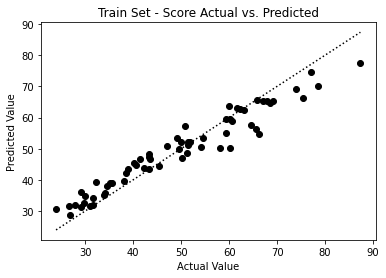

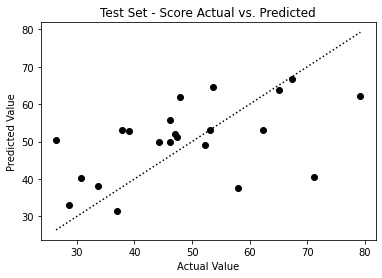

In [4]:
# Read in the data from the SQL Database
conn = pymssql.connect(server,username,password,database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query,conn)

#=================================================================================================================================================================#
### Clean it 
# Drop unnecessary columns
df.drop(['ASTHMA_ID',"NUM_ED_VISITS","COUNTY_ID","AQ_ID","YEAR"],axis=1, inplace=True, errors="ignore")
params = ["LEAD","NO2","OZONE","PM10","PM25","SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID",f"{param}_METRIC_ID",f"{param}_UNITS_ID"],axis=1,inplace=True,errors="ignore")

# Remove columns where at least 40% of the values are missing
df.dropna(axis=1,thresh=len(df)*0.4,inplace=True)
# print(df.columns)

# # Remove any rows that still have nulls
df.dropna(axis=0,how="any",inplace=True)

#=================================================================================================================================================================#
### Create a training set that's 75% of your data set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS',axis=1)
y = df['AGE_ADJ_ED_VISITS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data
st_x = StandardScaler().fit(X_train)
print(f"The parameters for the scaler is: {st_x.get_params()}")
X_train = st_x.transform(X_train)
X_test = st_x.transform(X_test)

#=================================================================================================================================================================#
### Run a Random Forest Regressor algorithm and compare ###
# Optimization - Could try using RandomizedSearchCV to speed this up
param_grid= {
    'n_estimators': [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,8500,9000,9500,10000],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [7,8,9,10,11,12,None],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False],
    'criterion': ["squared_error","poisson"]
}

rf=RandomForestRegressor(random_state=0)
rf_grid=GridSearchCV(estimator=rf,param_grid=param_grid,n_jobs=15,verbose=3,cv=5, error_score='raise')

rf_grid.fit(X_train, y_train)
print(f"The best parameters are: {rf_grid.best_params_}")

y_predict_forest = rf_grid.predict(X_test)

#=================================================================================================================================================================#
# Save the model
dump(rf_grid, 'random_forest_model_scaled.model')

#=================================================================================================================================================================#
# Model Results
MSE_forest=0
for i in range(len(y_predict_forest)):
    MSE_forest += (list(y_test)[i]-y_predict_forest[i])**2/len(y_test)
print(f"The MSE for forest was {MSE_forest:.2f}")
print(f"The R^2 score for non-imputed train set is {rf_grid.score(X_train,y_train)}")
print(f"The R^2 score for non-imputed test set is {rf_grid.score(X_test,y_test)}")

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_train),max(y_train),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest_train = rf_grid.predict(X_train)
plt.scatter(x=y_train,y=y_predict_forest_train,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Train Set - Score Actual vs. Predicted')

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_test),max(y_test),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest = rf_grid.predict(X_test)
plt.scatter(x=y_test,y=y_predict_forest,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Test Set - Score Actual vs. Predicted')

### Random Forest Regressor - Imputation (NO2, PM25, Ozone)

C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Fitting 5 folds for each of 6384 candidates, totalling 31920 fits
The best parameters are: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}


C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


The MSE for forest was 154.31, and MSE for forest imputed was 43.40
The R^2 score for imputed train set is 0.8796463446588011
The R^2 score for imputed test set is 0.053058349803256744


C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Test Set - Score Actual vs. Predicted')

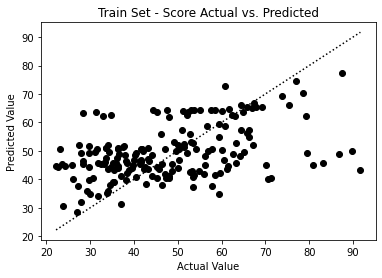

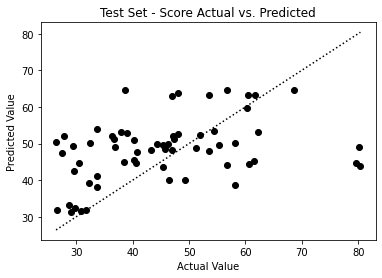

In [10]:
# Read in the data from the SQL Database
conn = pymssql.connect(server,username,password,database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query,conn)

#=================================================================================================================================================================#
# Drop unnecessary columns
df.drop(['ASTHMA_ID',"NUM_ED_VISITS","COUNTY_ID","AQ_ID","YEAR"],axis=1, inplace=True, errors="ignore")
params = ["LEAD","NO2","OZONE","PM10","PM25","SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID",f"{param}_METRIC_ID",f"{param}_UNITS_ID"],axis=1,inplace=True,errors="ignore")

# Remove columns where at least 50% of the values are missing
df.dropna(axis=1,thresh=len(df)*0.4,inplace=True)

# Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS',axis=1)
y = df['AGE_ADJ_ED_VISITS']
X_train, X_test_imputed, y_train, y_test_imputed = train_test_split(X, y, test_size=0.25, random_state=0)

# impute any rows that still have nulls
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train = imp.transform(X_train)
X_test_imputed = imp.transform(X_test_imputed)

#=================================================================================================================================================================#
### Run a Random Forest Regressor algorithm and compare ###
param_grid= {
    'n_estimators': [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,8500,9000,9500,10000],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [7,8,9,10,11,12,None],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False],
    'criterion': ["squared_error","poisson"]
}
rf=RandomForestRegressor(random_state=0)
rf_grid_imputed=GridSearchCV(estimator=rf,param_grid=param_grid,n_jobs=15,verbose=3,cv=5, error_score='raise')
rf_grid_imputed.fit(X_train, y_train)
print(f"The best parameters are: {rf_grid_imputed.best_params_}")
y_predict_forest_imputed = rf_grid.predict(X_test_imputed)

#=================================================================================================================================================================#
# Save the model
dump(rf_grid_imputed, 'random_forest_imputed_model.model')

#=================================================================================================================================================================#
# Model Results
MSE_forest_imputed=0
for i in range(len(y_predict_forest)):
    MSE_forest_imputed += (list(y_test_imputed)[i]-y_predict_forest_imputed[i])**2/len(y_test_imputed)
print(f"The MSE for forest was {MSE_forest:.2f}, and MSE for forest imputed was {MSE_forest_imputed:.2f}")
print(f"The R^2 score for imputed train set is {rf_grid_imputed.score(X_train,y_train)}")
print(f"The R^2 score for imputed test set is {rf_grid_imputed.score(X_test_imputed,y_test_imputed)}")


fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_train),max(y_train),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest_imputed_train = rf_grid.predict(X_train)
plt.scatter(x=y_train,y=y_predict_forest_imputed_train,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Train Set - Score Actual vs. Predicted')

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_test_imputed),max(y_test_imputed),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest_imputed = rf_grid.predict(X_test_imputed)
plt.scatter(x=y_test_imputed,y=y_predict_forest_imputed,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Test Set - Score Actual vs. Predicted')


### Random Forest Regressor - Imputation (NO2, PM10, PM25, Ozone, SO2, Lead)

C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Fitting 5 folds for each of 6384 candidates, totalling 31920 fits
The best parameters are: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}


C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


The MSE for forest was 154.31, and MSE for forest imputed was 43.40
The R^2 score for imputed train set is 0.8796463446588011
The R^2 score for imputed test set is 0.053058349803256744


C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Test Set - Score Actual vs. Predicted')

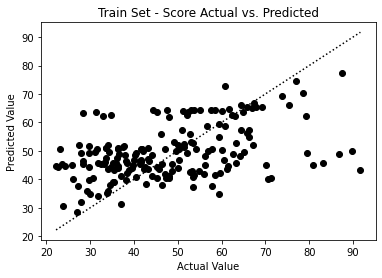

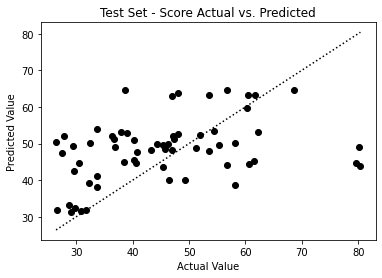

In [11]:
# Read in the data from the SQL Database
conn = pymssql.connect(server,username,password,database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query,conn)

#=================================================================================================================================================================#
# Drop unnecessary columns
df.drop(['ASTHMA_ID',"NUM_ED_VISITS","COUNTY_ID","AQ_ID","YEAR"],axis=1, inplace=True, errors="ignore")
params = ["LEAD","NO2","OZONE","PM10","PM25","SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID",f"{param}_METRIC_ID",f"{param}_UNITS_ID"],axis=1,inplace=True,errors="ignore")

# Remove columns where at least 50% of the values are missing
df.dropna(axis=1,thresh=len(df)*0.4,inplace=True)

# Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS',axis=1)
y = df['AGE_ADJ_ED_VISITS']
X_train, X_test_imputed, y_train, y_test_imputed = train_test_split(X, y, test_size=0.25, random_state=0)

# impute any rows that still have nulls
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train = imp.transform(X_train)
X_test_imputed = imp.transform(X_test_imputed)

#=================================================================================================================================================================#
### Run a Random Forest Regressor algorithm and compare ###
param_grid= {
    'n_estimators': [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,8500,9000,9500,10000],
    'max_features': ['auto','sqrt','log2'],
    'max_depth': [7,8,9,10,11,12,None],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False],
    'criterion': ["squared_error","poisson"]
}
rf=RandomForestRegressor(random_state=0)
rf_grid_imputed=GridSearchCV(estimator=rf,param_grid=param_grid,n_jobs=15,verbose=3,cv=5, error_score='raise')
rf_grid_imputed.fit(X_train, y_train)
print(f"The best parameters are: {rf_grid_imputed.best_params_}")
y_predict_forest_imputed = rf_grid.predict(X_test_imputed)

#=================================================================================================================================================================#
# Save the model
dump(rf_grid_imputed, 'random_forest_imputed_allparams_model.model')

#=================================================================================================================================================================#
# Model Results
MSE_forest_imputed=0
for i in range(len(y_predict_forest)):
    MSE_forest_imputed += (list(y_test_imputed)[i]-y_predict_forest_imputed[i])**2/len(y_test_imputed)
print(f"The MSE for forest was {MSE_forest:.2f}, and MSE for forest imputed was {MSE_forest_imputed:.2f}")
print(f"The R^2 score for imputed train set is {rf_grid_imputed.score(X_train,y_train)}")
print(f"The R^2 score for imputed test set is {rf_grid_imputed.score(X_test_imputed,y_test_imputed)}")


fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_train),max(y_train),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest_imputed_train = rf_grid.predict(X_train)
plt.scatter(x=y_train,y=y_predict_forest_imputed_train,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Train Set - Score Actual vs. Predicted')

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_test_imputed),max(y_test_imputed),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_forest_imputed = rf_grid.predict(X_test_imputed)
plt.scatter(x=y_test_imputed,y=y_predict_forest_imputed,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Test Set - Score Actual vs. Predicted')

### K-Nearest Neighbors Regression - No Imputation (NO2, PM25, Ozone)

C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits
The best parameters are: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
The MSE for K-Nearest Neighbors was 246.56
The R^2 score for non-imputed train set is 1.0
The R^2 score for non-imputed test set is -0.28880687573488406


Text(0.5, 1.0, 'Test Set - Score Actual vs. Predicted')

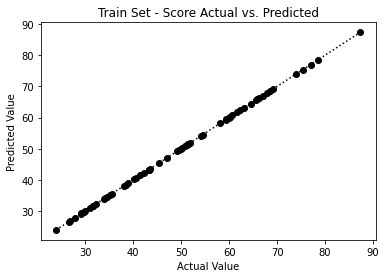

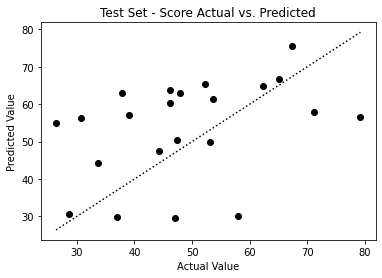

In [12]:
# Read in the data from the SQL Database
conn = pymssql.connect(server,username,password,database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query,conn)

#=================================================================================================================================================================#
### Clean it 
# Drop unnecessary columns
df.drop(['ASTHMA_ID',"NUM_ED_VISITS","COUNTY_ID","AQ_ID","YEAR"],axis=1, inplace=True, errors="ignore")
params = ["LEAD","NO2","OZONE","PM10","PM25","SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID",f"{param}_METRIC_ID",f"{param}_UNITS_ID"],axis=1,inplace=True,errors="ignore")

# Remove columns where at least 40% of the values are missing
df.dropna(axis=1,thresh=len(df)*0.4,inplace=True)

# # Remove any rows that still have nulls
df.dropna(axis=0,how="any",inplace=True)

#=================================================================================================================================================================#
### Create a training set that's 75% of your data set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS',axis=1)
y = df['AGE_ADJ_ED_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.fit_transform(X_test)

#=================================================================================================================================================================#
### Run a Random Forest Regressor algorithm and compare ###
# Optimization - Could try using RandomizedSearchCV to speed this up
param_grid= {
    'n_neighbors': [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'weights': ['uniform','distance'],
    'p': [1,2]
}

km=KNeighborsRegressor()
km_grid=GridSearchCV(estimator=km,param_grid=param_grid,n_jobs=15,verbose=3,cv=5, error_score='raise')

km_grid.fit(X_train, y_train)
print(f"The best parameters are: {km_grid.best_params_}")

y_predict = km_grid.predict(X_test)

#=================================================================================================================================================================#
# Save the model
dump(km_grid, 'KNearestNeighbors_model.model')

#=================================================================================================================================================================#
# Model Results
MSE=0
for i in range(len(y_predict)):
    MSE += (list(y_test)[i]-y_predict[i])**2/len(y_test)
print(f"The MSE for K-Nearest Neighbors was {MSE:.2f}")
print(f"The R^2 score for non-imputed train set is {km_grid.score(X_train,y_train)}")
print(f"The R^2 score for non-imputed test set is {km_grid.score(X_test,y_test)}")

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_train),max(y_train),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_train = km_grid.predict(X_train)
plt.scatter(x=y_train,y=y_predict_train,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Train Set - Score Actual vs. Predicted')

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_test),max(y_test),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict = km_grid.predict(X_test)
plt.scatter(x=y_test,y=y_predict,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Test Set - Score Actual vs. Predicted')

### K-Nearest Neighbors Regression - Imputation (NO2, PM25, Ozone)

C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits
The best parameters are: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
The MSE for K-Nearest Neighbors was 166.26
The R^2 score for imputed train set is 1.0
The R^2 score for imputed test set is 0.07883176068870279


Text(0.5, 1.0, 'Test Set - Score Actual vs. Predicted')

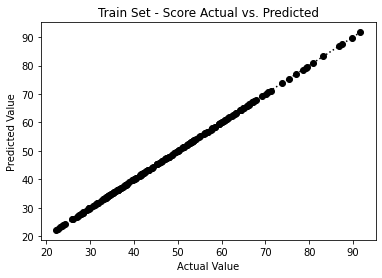

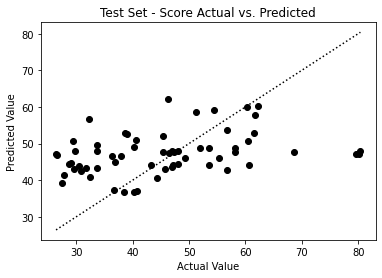

In [13]:
# Read in the data from the SQL Database
conn = pymssql.connect(server,username,password,database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query,conn)

#=================================================================================================================================================================#
### Clean it 
# Drop unnecessary columns
df.drop(['ASTHMA_ID',"NUM_ED_VISITS","COUNTY_ID","AQ_ID","YEAR"],axis=1, inplace=True, errors="ignore")
params = ["LEAD","NO2","OZONE","PM10","PM25","SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID",f"{param}_METRIC_ID",f"{param}_UNITS_ID"],axis=1,inplace=True,errors="ignore")

# Remove columns where at least 40% of the values are missing
df.dropna(axis=1,thresh=len(df)*0.4,inplace=True)

# Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS',axis=1)
y = df['AGE_ADJ_ED_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# impute any rows that still have nulls
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Scale the data
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.fit_transform(X_test)
#=================================================================================================================================================================#
### Run a Random Forest Regressor algorithm and compare ###
# Optimization - Could try using RandomizedSearchCV to speed this up
param_grid= {
    'n_neighbors': [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'weights': ['uniform','distance'],
    'p': [1,2]
}

km=KNeighborsRegressor()
km_grid=GridSearchCV(estimator=km,param_grid=param_grid,n_jobs=15,verbose=3,cv=5, error_score='raise')

km_grid.fit(X_train, y_train)
print(f"The best parameters are: {km_grid.best_params_}")

y_predict = km_grid.predict(X_test)

#=================================================================================================================================================================#
# Save the model
dump(km_grid, 'KNearestNeighbors_imputed_model.model')

#=================================================================================================================================================================#
# Model Results
MSE=0
for i in range(len(y_predict)):
    MSE += (list(y_test)[i]-y_predict[i])**2/len(y_test)
print(f"The MSE for K-Nearest Neighbors was {MSE:.2f}")
print(f"The R^2 score for imputed train set is {km_grid.score(X_train,y_train)}")
print(f"The R^2 score for imputed test set is {km_grid.score(X_test,y_test)}")

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_train),max(y_train),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_train = km_grid.predict(X_train)
plt.scatter(x=y_train,y=y_predict_train,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Train Set - Score Actual vs. Predicted')

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_test),max(y_test),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict = km_grid.predict(X_test)
plt.scatter(x=y_test,y=y_predict,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Test Set - Score Actual vs. Predicted')

### K-Nearest Neighbors Regression - Imputation (NO2, PM10, PM25, Ozone, SO2, Lead)

C:\Users\jbartell\Anaconda3\envs\PowerBI\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Fitting 5 folds for each of 72 candidates, totalling 360 fits
The best parameters are: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
The MSE for K-Nearest Neighbors was 167.43
The R^2 score for imputed all params train set is 1.0
The R^2 score for imputed all params test set is 0.07235062913479084


Text(0.5, 1.0, 'Test Set - Score Actual vs. Predicted')

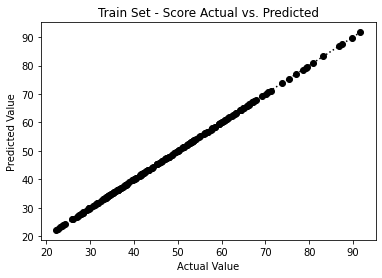

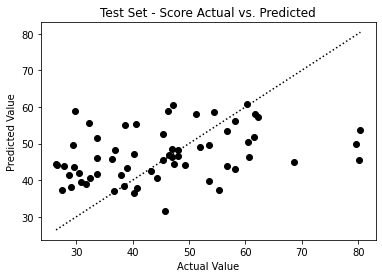

In [14]:
# Read in the data from the SQL Database
conn = pymssql.connect(server,username,password,database)
cursor = conn.cursor()
query = f"""
    SELECT * FROM {asthma_table}
    INNER JOIN {aq_table} ON {aq_table}.AQ_ID = {asthma_table}.AQ_ID 
    WHERE {asthma_table}.YEAR != 2021
"""
df = pd.read_sql(query,conn)

#=================================================================================================================================================================#
### Clean it 
# Drop unnecessary columns
df.drop(['ASTHMA_ID',"NUM_ED_VISITS","COUNTY_ID","AQ_ID","YEAR"],axis=1, inplace=True, errors="ignore")
params = ["LEAD","NO2","OZONE","PM10","PM25","SO2"]
for param in params:
    df.drop([f"{param}_METHOD_ID",f"{param}_METRIC_ID",f"{param}_UNITS_ID"],axis=1,inplace=True,errors="ignore")

# Create a training set that's 75% of your dat set and a complementary test set with the remaining 25%. Specify random_state = 0 ###
X = df.drop('AGE_ADJ_ED_VISITS',axis=1)
y = df['AGE_ADJ_ED_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# impute any rows that still have nulls
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Scale the data
st_x = StandardScaler()
X_train = st_x.fit_transform(X_train)
X_test = st_x.fit_transform(X_test)
#=================================================================================================================================================================#
### Run a Random Forest Regressor algorithm and compare ###
# Optimization - Could try using RandomizedSearchCV to speed this up
param_grid= {
    'n_neighbors': [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'weights': ['uniform','distance'],
    'p': [1,2]
}

km=KNeighborsRegressor()
km_grid=GridSearchCV(estimator=km,param_grid=param_grid,n_jobs=15,verbose=3,cv=5, error_score='raise')

km_grid.fit(X_train, y_train)
print(f"The best parameters are: {km_grid.best_params_}")

y_predict = km_grid.predict(X_test)

#=================================================================================================================================================================#
# Save the model
dump(km_grid, 'KNearestNeighbors_imputed_all_model.model')

#=================================================================================================================================================================#
# Model Results
MSE=0
for i in range(len(y_predict)):
    MSE += (list(y_test)[i]-y_predict[i])**2/len(y_test)
print(f"The MSE for K-Nearest Neighbors was {MSE:.2f}")
print(f"The R^2 score for imputed all params train set is {km_grid.score(X_train,y_train)}")
print(f"The R^2 score for imputed all params test set is {km_grid.score(X_test,y_test)}")

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_train),max(y_train),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict_train = km_grid.predict(X_train)
plt.scatter(x=y_train,y=y_predict_train,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Train Set - Score Actual vs. Predicted')

fig=plt.figure()
ax=plt.axes()
x=np.linspace(min(y_test),max(y_test),1000)
ax.plot(x,x,color='black',linestyle='dotted')
y_predict = km_grid.predict(X_test)
plt.scatter(x=y_test,y=y_predict,c='black')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Test Set - Score Actual vs. Predicted')